In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF" -O hw3_data.zip && rm -rf /tmp/cookies.txt
!unzip -qq hw3_data.zip -d dul_2021/Homework/hw6/data
!rm hw3_data.zip
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 235, done.
remote: Counting objects: 100% (235/235), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 235 (delta 107), reused 213 (delta 90), pack-reused 0
Receiving objects: 100% (235/235), 30.56 MiB | 30.12 MiB/s, done.
Resolving deltas: 100% (107/107), done.
--2021-12-07 20:29:30--  https://docs.google.com/uc?export=download&confirm=DzZV&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF
Resolving docs.google.com (docs.google.com)... 64.233.191.138, 64.233.191.101, 64.233.191.139, ...
Connecting to docs.google.com (docs.google.com)|64.233.191.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-1k-docs.googleusercontent.com/docs/securesc/ie89ue05hvo4crbrkq87iqb50flt1ko4/5mqfcgb006ibe3usr5fhqu3lpc3tuq00/1638908925000/06419056966375271799/13391669191714471808Z/1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF?e=download [following]
--2021-12-07 20:29:30--  https://doc-10-1k-docs.go

In [2]:
from dul_2021.utils.hw6_utils import *

In [3]:
from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import matplotlib.pyplot as plt
import torch.optim as opt
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from torch.distributions.beta import Beta

import copy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from scipy.stats import norm
from scipy.optimize import bisect
from tqdm import trange, tqdm_notebook
from torch.utils import data
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1: VAEs on Images
In this question, you will train VAE model on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

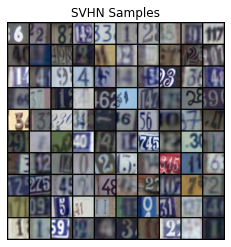

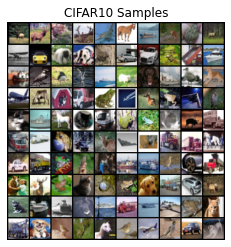

In [4]:
visualize_svhn()
visualize_cifar10()


(10479, 20, 20, 1)


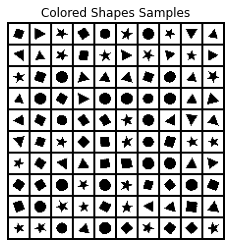

In [4]:
visualize_colored_shapes()

## VAE with AF Prior
In this part, implement a VAE with an Autoregressive Flow prior ([VLAE](https://arxiv.org/abs/1611.02731)) with the following characteristics:

*   16-dim latent variables $z$ with a MADE prior, with $\epsilon \sim N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can use the same encoder / decoder architectures and training hyperparameters as in homework 5. For your MADE prior, it would suffice to use two hidden layers of size $512$. More explicitly, your MADE AF (mapping from $z\rightarrow \epsilon$) should output location $\mu_\psi(z)$ and scale parameters $\sigma_\psi(z)$ and do the following transformation on $z$:
$$\epsilon = z \odot \sigma_\psi(z) + \mu_\psi(z)$$

where the $i$th element of $\sigma_\psi(z)$ is computed from $z_{<i}$ (same for $\mu_\psi(z)$) and optimize the objective

$$-E_{z\sim q(z|x)}[\log{p(x|z)}] + E_{z\sim q(z|x)}[\log{q(z|x)} - \log{p(z)}]$$
where $$\log{p(z)} = \log{p(\epsilon)} + \log{\det\left|\frac{d\epsilon}{dz}\right|}$$





**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)




In [5]:
# MADE

class MaskedLinear(nn.Linear):    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)


class MADE(nn.Module):
    def __init__(self, in_dim=16, val_num=2, hidden_dim=150, hidden_layers_num=1):
        super().__init__()

        self.m = {}

        # some init
        self.in_dim = in_dim
        self.val_num = val_num
        self.model = self.model_init(in_dim, val_num, hidden_dim, hidden_layers_num)

    def model_init(self, in_dim, val_num, hidden_dim, hidden_layers_num, ordering=None):
        if ordering is None:
            self.m[-1] = np.arange(in_dim)
        else:
            self.m[-1] = ordering

        # стакаем слои
        layers = []
        layer_0 = MaskedLinear(in_dim, hidden_dim) #  * val_num
        act_0 = nn.ReLU()
        layers.extend([layer_0, act_0])
        for i in range(hidden_layers_num - 1):
            self.m[i] = np.random.randint(self.m[i - 1].min(), self.in_dim - 1, size=hidden_dim)
            layer_i = MaskedLinear(hidden_dim, hidden_dim)
            act_i = nn.ReLU()
            layers.extend([layer_i, act_i])
        
        layer_n = MaskedLinear(hidden_dim, in_dim * val_num)  #########################
        layers.append(layer_n)
        i = hidden_layers_num - 1
        self.m[i] = np.random.randint(self.m[i - 1].min(), self.in_dim - 1, size=hidden_dim) ######

        # собираем маски и добавляем нагенеренные маски в соответствующие слои
        masks = [self.m[i-1][:, None] <= self.m[i][None, :] for i in range(hidden_layers_num)]
        masks.append(self.m[hidden_layers_num - 1][:, None] < self.m[-1][None, :])
        masks[-1] = np.repeat(masks[-1], val_num, axis=1)
        masks[0] = np.repeat(masks[0], 1, axis=0) # 1 -- > val_num
 
        for i in range(len(masks)):
            layers[2 * i].set_mask(masks[i])

        model = nn.Sequential(*layers)
        return model

    def forward(self, x):
        # x [bs, in_dim]
        x = x.view(-1, self.in_dim) 
        logits = self.model(x) # [bs, in_dim * val_num]
        logits = logits.view(-1, self.in_dim, self.val_num) 
        return logits 

In [5]:
# VAE

class Encoder(nn.Module):
    def __init__(self, in_ch=3, latent_dim=16):
        super().__init__()
        self.latent_dim = latent_dim
        self.conv1 = nn.Conv2d(in_ch, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 2, 1)   # 16 x 16
        self.conv3 = nn.Conv2d(64, 128, 3, 2, 1)  # 8 x 8
        self.conv4 = nn.Conv2d(128, 256, 3, 2, 1) # 4 x 4
        self.linear = nn.Linear(4 * 4 * 256, 2 * latent_dim)

        
    def forward(self, x):
        bs = x.shape[0]
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        out = out.contiguous().view(bs, -1)
        out = self.linear(out)
        return out
        

class Decoder(nn.Module):
    def __init__(self, in_ch=3, latent_dim=16):
        super().__init__()
        self.latent_dim = latent_dim
        self.linear = nn.Linear(latent_dim, 4 * 4 * 128)
        self.t_conv1 = nn.ConvTranspose2d(128, 128, 4, 2, 1) # 8 x 8
        self.t_conv2 = nn.ConvTranspose2d(128, 64, 4, 2, 1)  # 16 x 16
        self.t_conv3 = nn.ConvTranspose2d(64, 32, 4, 2, 1)   # 32 x 32
        self.conv = nn.Conv2d(32, in_ch, 3, 1, 1)

        
    def forward(self, x):
        bs = x.shape[0]
        out = F.relu(self.linear(x))
        out = out.view(bs, 4, 4, 128)
        out = out.permute(0, 3, 1, 2)
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        out = F.relu(self.t_conv3(out))
        out = self.conv(out)
        return out   


class VAE_AF(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder()
        self.decoder = Decoder()

        self.lat_dist = Normal(torch.Tensor([0.]).to(device), torch.Tensor([1.]).to(device))
        self.made = MADE(in_dim=16, val_num=2, hidden_dim=512, hidden_layers_num=2)


    def forward(self, x):

        mu_z, log_sig_z = self.encoder(x).chunk(2, dim=1)
        z_sample = self.lat_dist.sample(mu_z.shape).squeeze(2)
        z_sample = z_sample * log_sig_z.exp() + mu_z
        z_sample = z_sample.to(device)
        mu_x = self.decoder(z_sample)
        return mu_x


    def loss(self, x):
        bs = x.shape[0]

        mu_z, log_sig_z = self.encoder(x).chunk(2, dim=1)
        z = self.lat_dist.sample(mu_z.shape).squeeze(2)
        z = z * log_sig_z.exp() + mu_z
        z = z.to(device) # [128, 16]

        mu_x = self.decoder(z)
        rec_loss = (x - mu_x) ** 2  # = -c * log_prob 
        rec_loss = rec_loss.view(bs, -1).sum(1).mean()


        log_qz_x = -0.5 * np.log(2 * np.pi) - log_sig_z - 0.5 * (z - mu_z) ** 2 * torch.exp(-2 * log_sig_z)

        # made(z) [bs, 16, 2]
        mu_eps, log_sig_eps = self.made(z).chunk(2, dim=-1) # [bs, 16, 1], [bs, 16, 1]


        mu_eps = mu_eps.squeeze(2) # [128, 16]
        log_sig_eps = log_sig_eps.squeeze(2) # [128, 16]
                                                      
        eps = z * torch.exp(log_sig_eps) + mu_eps
        log_pz = -0.5 * np.log(2 * np.pi) - 0.5 * eps ** 2 + log_sig_eps
        kl = (log_qz_x - log_pz).sum(1).mean()
        return rec_loss, kl


    def test(self, testloader):
        loss = 0
        tl = 0
        kl = 0
        log_prob = 0
        with torch.no_grad():
            for batch in testloader:
                batch = batch.to(device)
                lp, kl_b = self.loss(batch)
                loss += (lp + kl_b) * batch.shape[0]
                kl += kl_b * batch.shape[0]
                log_prob += lp * batch.shape[0]
                tl += batch.shape[0]
        return np.array([loss / tl, log_prob / tl, kl / tl])


    def fit(self, train_data, test_data, lr=1e-3, num_epochs=100, bs=128):
        trainloader = data.DataLoader(train_data,
                                      batch_size=bs, 
                                      shuffle=True)
        
        testloader = torch.utils.data.DataLoader(test_data, 
                                                 batch_size=bs)

        optim = opt.Adam(self.parameters(), lr=lr)
        
        train_loss = None
        test_loss = self.test(testloader)

        for epoch in range(num_epochs):
            for batch in trainloader:
                batch = batch.to(device)
                lp, kl = self.loss(batch)
                loss = lp + kl
                optim.zero_grad()
                loss.backward()
                optim.step()
                
                if train_loss is None:
                    train_loss = np.array([loss.cpu().detach().numpy(),
                                           kl.cpu().detach().numpy(),
                                           lp.cpu().detach().numpy()])
                else:
                    train_loss = np.vstack((train_loss,
                                           np.array([loss.cpu().detach().numpy(),
                                           kl.cpu().detach().numpy(),
                                           lp.cpu().detach().numpy()])))
            
            
            cur_test_loss = self.test(testloader)
            print(f'Epoch {epoch + 1}: -ELBO= {cur_test_loss[0]:.4f}, Recon Loss= {cur_test_loss[1]:.4f}, KL Loss= {cur_test_loss[2]:.4f}')
            test_loss = np.vstack((test_loss, cur_test_loss))
        
        return train_loss, test_loss


    def sample(self, n=100):
        with torch.no_grad():
            z = self.lat_dist.sample((n, self.latent_dim)).squeeze(2)
            for i in range(self.latent_dim):
                mu_eps, log_sig_eps = self.made(z)[:, i].chunk(2, dim=-1)

                # print(mu_eps.shape, log_sig_eps.shape)
                mu_eps = mu_eps.squeeze(1)
                log_sig_eps = log_sig_eps.squeeze(1)
                z[:, i] = (z[:, i] - mu_eps) / torch.exp(log_sig_eps)

            mu_x = self.decoder(z)
            x = mu_x
            x = torch.clip(x, -1, 1)
        return x.cpu().detach().numpy()


    def interpolations(self, images):
        with torch.no_grad():

            bs = images.shape[0]
            mu_z, log_sig_z = self.encoder(images).chunk(2, dim=1)
            z = self.lat_dist.sample(mu_z.shape).squeeze(2)
            z = z * log_sig_z.exp() + mu_z
    
            z = z.to(device)
            z1 = z[:10]
            z2 = z[10:]

            z_inter = [(z1 * (1 - phi) + z2 * phi) for phi in np.linspace(0, 1, 10)]
            z_inter = torch.cat(z_inter)

            x_inter_mu = self.decoder(z_inter)
            x_inter_mu = torch.clip(x_inter_mu, -1, 1)
            return x_inter_mu.cpu().detach().numpy()


### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [34]:
def q1(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """

    # data preparing
    train_data = torch.tensor(train_data.transpose(0, 3, 1, 2))
    train_data = (train_data / 255 - 0.5) / 0.5
    test_data = torch.tensor(test_data.transpose(0, 3, 1, 2))
    test_data = (test_data / 255 - 0.5) / 0.5

    # model initialization
    vae = VAE_AF()
    vae.to(device)
    
    # training
    train_info, test_info = vae.fit(train_data, test_data, num_epochs=20)

    # samples
    samples = vae.sample()
    samples = ((samples + 1) / 2 * 255).transpose(0, 2, 3, 1).astype(np.uint8)


    # reconstructions
    real_images_idxs = np.random.choice(np.arange(len(test_data)), size=(50,), replace=False)
    real_images_idxs = torch.tensor(real_images_idxs)
    real_images = test_data[real_images_idxs].to(device)
    reconstruct_images = vae(real_images)
    reconstruct_images = torch.clip(reconstruct_images, -1, 1)

    real_images = real_images.permute(0, 2, 3, 1).detach().cpu().numpy()
    reconstruct_images = reconstruct_images.permute(0, 2, 3, 1).detach().cpu().numpy()

    real_reconstruct = np.stack([real_images, reconstruct_images], axis=1)
    real_reconstruct = real_reconstruct.reshape(-1, 32, 32, 3)
    real_reconstruct = ((real_reconstruct + 1) / 2 * 255).astype(np.uint8)

    # interpolation
    real_images_idxs = np.random.choice(np.arange(len(test_data)), size=(20,), replace=False)
    real_images_idxs = torch.tensor(real_images_idxs)
    real_images = test_data[real_images_idxs].to(device)
    interpolations = vae.interpolations(real_images)
    interpolations = ((interpolations + 1) / 2 * 255).transpose(0, 2, 3, 1).astype(np.uint8)

    return train_info, test_info, samples, real_reconstruct, interpolations

### Results
Once you've finished `q1`, execute the cells below to visualize and save your results.

Epoch 1: -ELBO= 264.8865, Recon Loss= 258.0480, KL Loss= 6.8386
Epoch 2: -ELBO= 191.6838, Recon Loss= 181.3283, KL Loss= 10.3554
Epoch 3: -ELBO= 170.9895, Recon Loss= 158.0533, KL Loss= 12.9362
Epoch 4: -ELBO= 142.3101, Recon Loss= 126.4030, KL Loss= 15.9070
Epoch 5: -ELBO= 138.1655, Recon Loss= 120.2625, KL Loss= 17.9031
Epoch 6: -ELBO= 128.8904, Recon Loss= 110.5638, KL Loss= 18.3267
Epoch 7: -ELBO= 125.1674, Recon Loss= 105.6906, KL Loss= 19.4768
Epoch 8: -ELBO= 122.3472, Recon Loss= 102.2302, KL Loss= 20.1170
Epoch 9: -ELBO= 112.6812, Recon Loss= 91.1753, KL Loss= 21.5059
Epoch 10: -ELBO= 118.5307, Recon Loss= 95.9188, KL Loss= 22.6119
Epoch 11: -ELBO= 110.9680, Recon Loss= 88.3741, KL Loss= 22.5939
Epoch 12: -ELBO= 109.2213, Recon Loss= 85.5186, KL Loss= 23.7028
Epoch 13: -ELBO= 106.5637, Recon Loss= 84.4954, KL Loss= 22.0684
Epoch 14: -ELBO= 103.8208, Recon Loss= 80.8516, KL Loss= 22.9692
Epoch 15: -ELBO= 103.9854, Recon Loss= 81.9408, KL Loss= 22.0446
Epoch 16: -ELBO= 104.8648, 

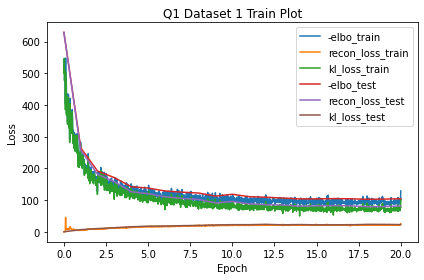

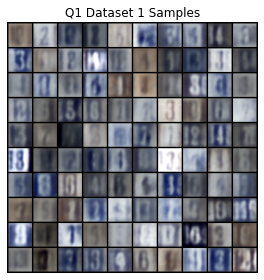

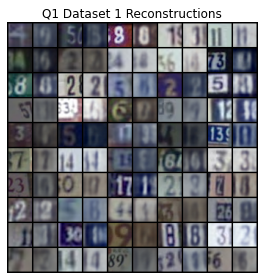

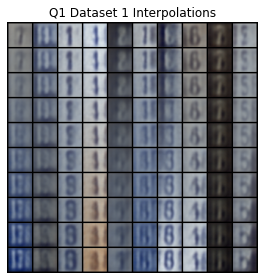

In [35]:
q1_save_results(1, q1)

Epoch 1: -ELBO= 283.1629, Recon Loss= 257.0387, KL Loss= 26.1242
Epoch 2: -ELBO= 248.4768, Recon Loss= 220.7064, KL Loss= 27.7704
Epoch 3: -ELBO= 245.2110, Recon Loss= 216.5888, KL Loss= 28.6222
Epoch 4: -ELBO= 243.2205, Recon Loss= 214.5268, KL Loss= 28.6937
Epoch 5: -ELBO= 242.9082, Recon Loss= 213.2751, KL Loss= 29.6331
Epoch 6: -ELBO= 241.2929, Recon Loss= 212.8450, KL Loss= 28.4478
Epoch 7: -ELBO= 241.2127, Recon Loss= 212.4055, KL Loss= 28.8071
Epoch 8: -ELBO= 239.5734, Recon Loss= 210.2932, KL Loss= 29.2803
Epoch 9: -ELBO= 244.2929, Recon Loss= 214.7809, KL Loss= 29.5120
Epoch 10: -ELBO= 238.7827, Recon Loss= 209.3627, KL Loss= 29.4200
Epoch 11: -ELBO= 238.6861, Recon Loss= 209.7220, KL Loss= 28.9641
Epoch 12: -ELBO= 237.6521, Recon Loss= 209.2250, KL Loss= 28.4271
Epoch 13: -ELBO= 237.6155, Recon Loss= 209.3069, KL Loss= 28.3086
Epoch 14: -ELBO= 237.6559, Recon Loss= 207.7711, KL Loss= 29.8848
Epoch 15: -ELBO= 237.8549, Recon Loss= 208.5113, KL Loss= 29.3436
Epoch 16: -ELBO= 23

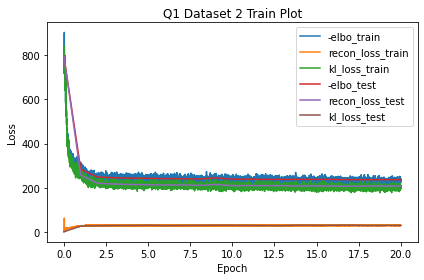

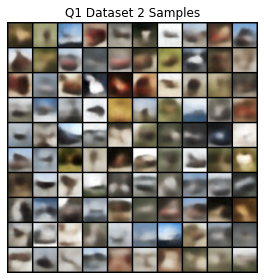

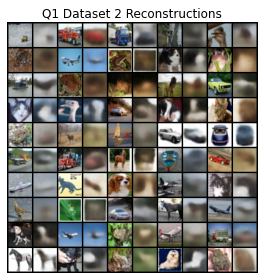

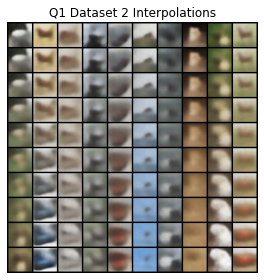

In [36]:
q1_save_results(2, q1)

# Question 2: VQ-VAE
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder): 
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch

In addition to training the VQ-VAE, you will also need to train a PixelCNN prior on the categorical latents in order to sample. For your architecture, you may find the following useful:
*   Since the input is a 2D grid of discrete values, you should have an input (learned) embedding layer to map the discrete values to embeddings of length $64$
*   Use a single Type A masked convolutions followed by 10-15 residual blocks (same structure as HW 1), and $2$ $1\times 1$ convolutions of $512$ and $K$ channels respectively.
*   You may find normalization methods (e.g. BatchNorm, LayerNorm) to be useful
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and PixelCNN prior**. Code is provided that automatically plots the training curves. 
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and PixelCNN prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [56]:
# Pixel CNN

class ResBlock(nn.Module):
    def __init__(self, in_ch, cf=120):
        super().__init__()

        self.block = nn.Sequential(
            nn.ReLU(), nn.Conv2d(in_ch, cf, 1),
            nn.ReLU(), ConvB(cf, cf, 7, 1, 3),
            nn.ReLU(), nn.Conv2d(cf, in_ch, 1),
        )
    def forward(self, x):
        out = self.block(x)
        out += x
        return out

class LayerNorm(nn.LayerNorm):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def forward(self, x):
    x = x.permute(0, 2, 3, 1).contiguous()
    x_shape = x.shape
    x = super().forward(x)
    return x.permute(0, 3, 1, 2).contiguous()


class MaskedConv(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.set_mask()
    
    def forward(self, x):
        # self.weight.data *= mask
        return F.conv2d(x, self.mask * self.weight, bias=self.bias, stride=self.stride, padding=self.padding)

    def set_mask(self):
        raise NotImplementedError()

class ConvA(MaskedConv):
    def set_mask(self):
        h, w = self.kernel_size
        self.mask[:, :, h // 2, : w // 2] = 1
        self.mask[:, :, :h // 2] = 1
    
class ConvB(MaskedConv):
    def set_mask(self):
        h, w = self.kernel_size
        self.mask[:, :, h // 2, : w // 2 + 1] = 1
        self.mask[:, :, :h // 2] = 1


class PixelCNN(nn.Module):
    def __init__(self, input_shape=(8, 8), dim=64, cf=120, rb_num=4, cb_size=128): # надо бы 10-15 блоков
        super().__init__()
        self.emb_layer = nn.Embedding(cb_size, dim)

        self.input_shape = input_shape
        self.cb_size = cb_size

        layers = [nn.ReLU(), ConvA(dim, cf, 7, 1, 3)]
        layers.extend([ResBlock(cf, cf), LayerNorm(cf)] * rb_num)
        layers.extend([nn.ReLU(), ConvB(cf, 512, 1),
                       nn.ReLU(), ConvB(512, cb_size, 1)])
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        bs = x.shape[0]
        out = self.emb_layer(x.long()).permute(0, 3, 1, 2).contiguous() # .long()?
        out = self.model(out)
        out = out.view(bs, self.cb_size, *self.input_shape)
        return out

    def nll(self, x):
        # print('x', x.dtype)
        out = self(x.long())
        # print('out', out.shape)
        return F.cross_entropy(self(x), x.long())


    def test(self, testloader):
        with torch.no_grad():
            loss = 0
            tc = 0
            for batch in testloader:
                loss = self.nll(batch.to(device).float()) * batch.shape[0]
                tc += batch.shape[0]
            return loss / tc
                

    def fit(self, train_data, test_data, num_epochs=20, lr=1e-3, batch_size=128):

        trainloader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        testloader = data.DataLoader(test_data, batch_size=batch_size)

        train_loss = []
        test_loss = []

        optim = opt.Adam(self.parameters(), lr=lr)

        test_loss.append(self.test(testloader))

        for epoch in tqdm(range(num_epochs)):
            for batch in trainloader:
                loss = self.nll(batch.to(device).float())
                optim.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), 1)
                optim.step()

                train_loss.append(loss.cpu().data)
            test_loss_val = self.test(testloader)
            test_loss.append(test_loss_val)
            print(f'Epoch {epoch + 1}:', test_loss_val.item())
        return train_loss, test_loss


    def sample(self, n=100):
        samples = torch.zeros(n, *self.input_shape).long().cuda()
        h, w = self.input_shape
        with torch.no_grad():
            for i in range(h):
                for j in range(w):
                    logits = self(samples)[:, :, i, j]
                    logits = F.softmax(logits, dim=1)
                    samples[:, i, j] = torch.multinomial(logits, 1).squeeze(-1)
        return samples

In [57]:
class Codebook(nn.Module):

    def __init__(self, cb_size=128, dim=256):
        super().__init__()
        self.embedding = nn.Embedding(cb_size, dim)
        self.embedding.weight.data.uniform_(-1 / cb_size, 1 / cb_size)
        self.dim = dim
        self.cb_size = cb_size

    def forward(self, z):
        # z [bs, 256, 8, 8]
        b, c, h, w = z.shape
        weight = self.embedding.weight

        z_flat = z.permute(0, 2, 3, 1).contiguous().view(-1, self.dim)

        # находим ближайшие в codebook
        distances = (z_flat ** 2).sum(dim=1, keepdim=True)
        distances = distances - 2 * torch.mm(z_flat, weight.t())
        distances = distances + (weight.t() ** 2).sum(dim=0, keepdim=True)
        indices = torch.argmin(distances, dim=1).view(b, h, w)

        zq = self.embedding(indices).permute(0, 3, 1, 2).contiguous() # z_q(x)

        return zq, z + (zq - z).detach(), indices

In [58]:
# VQ-VAE

class ResBlockVAE(nn.Module):
    def __init__(self, dim=256):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(dim)
        self.bn2 = nn.BatchNorm2d(dim)
        self.conv1 = nn.Conv2d(dim, dim, 3, 1, 1)
        self.conv2 = nn.Conv2d(dim, dim, 1, 1, 0)

        
    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(x)))
        return out


class Encoder(nn.Module):
    def __init__(self, in_ch=3, dim=256):
        super().__init__()
        self.bn = nn.BatchNorm2d(dim)
        self.conv1 = nn.Conv2d(in_ch, dim, 4, 2, 1) # 16 x 16
        self.conv2 = nn.Conv2d(dim, dim, 4, 2, 1)   # 8 x 8
        self.rb1 = ResBlockVAE(dim)
        self.rb2 = ResBlockVAE(dim)

        
    def forward(self, x):
        out = F.relu(self.bn(self.conv1(x)))
        out = self.rb2(self.rb1(self.conv2(out)))
        return out
        

class Decoder(nn.Module):
    def __init__(self, in_ch=3, dim=256):
        super().__init__()
        self.rb1 = ResBlockVAE(dim)
        self.rb2 = ResBlockVAE(dim)
        self.bn1 = nn.BatchNorm2d(dim)
        self.bn2 = nn.BatchNorm2d(dim)
        self.t_conv1 = nn.ConvTranspose2d(dim, dim, 4, 2, 1) # 16 x 16
        self.t_conv2 = nn.ConvTranspose2d(dim, in_ch, 4, 2, 1)  # 32 x 32

        
    def forward(self, x):
        out = F.relu(self.bn1(self.rb2(self.rb1(x))))
        out = F.relu(self.bn2(self.t_conv1(out)))
        out = self.t_conv2(out)
        return out   


class VQ_VAE(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.codebook = Codebook()

        # self.lat_dist = Normal(torch.Tensor([0.]).to(device), torch.Tensor([1.]).to(device))
        # self.made = MADE(in_dim=16, val_num=2, hidden_dim=512, hidden_layers_num=2)


    def forward(self, x):

        z = self.encoder(x)
        e, e_sg, _ = self.codebook(z)
        x_rec = self.decoder(e_sg)

        term1 = torch.mean((z - e.detach()) ** 2)
        term2 = torch.mean((e - z.detach()) ** 2)
        return x_rec, term1 + term1


    def loss(self, x):
        x_rec, add_term = self(x)
        rec_loss = F.mse_loss(x_rec, x)
        loss = rec_loss + add_term
        return loss


    def test(self, testloader):
        loss = 0
        tl = 0
        with torch.no_grad():
            for batch in testloader:
                batch = batch.to(device)
                lp = self.loss(batch)
                loss += lp * batch.shape[0]
                tl += batch.shape[0]
        return loss / tl


    def fit(self, train_data, test_data, lr=1e-3, num_epochs=100, bs=128):
        trainloader = data.DataLoader(train_data,
                                      batch_size=bs, 
                                      shuffle=True)
        
        testloader = torch.utils.data.DataLoader(test_data, 
                                                 batch_size=bs)

        optim = opt.Adam(self.parameters(), lr=lr)
        
        train_loss = []
        test_loss = [self.test(testloader)]

        for epoch in range(num_epochs):
            for batch in trainloader:
                batch = batch.to(device)
                loss = self.loss(batch)
                optim.zero_grad()
                loss.backward()
                optim.step()

                train_loss.append(loss.detach().cpu().data)
            
            cur_test_loss = self.test(testloader)
            print(f'Epoch {epoch + 1}: Loss = {cur_test_loss:.4f}')
            test_loss.append(cur_test_loss)
        
        return train_loss, test_loss

In [59]:
def q2(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """

    # data preparing
    train_data = torch.tensor(train_data.transpose(0, 3, 1, 2))
    train_data = (train_data / 255 - 0.5) / 0.5
    test_data = torch.tensor(test_data.transpose(0, 3, 1, 2))
    test_data = (test_data / 255 - 0.5) / 0.5

    # model initialization
    vae = VQ_VAE()
    vae.to(device)
    
    # vae training
    train_losses, test_losses = vae.fit(train_data, test_data, num_epochs=20)

    # prior training

    prior = PixelCNN()
    prior.to(device)

    z_train_data = []
    train_loader = data.DataLoader(test_data, batch_size=128, shuffle=False)
    with torch.no_grad():
        for x in train_loader:
            x = x.cuda()
            z = vae.encoder(x)
            indices = vae.codebook(z)[2]
            z_train_data.append(indices.long())
    z_train_data =  torch.cat(z_train_data, dim=0)


    z_test_data = []
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=False)
    with torch.no_grad():
        for x in train_loader:
            x = x.cuda()
            z = vae.encoder(x)
            indices = vae.codebook(z)[2]
            z_test_data.append(indices.long())
    z_test_data =  torch.cat(z_test_data, dim=0)

    prior_train_losses, prior_test_losses = prior.fit(z_train_data, z_test_data, num_epochs=20)



    # samples
    with torch.no_grad():
        z_ = prior.sample(100).long()
        z = vae.codebook.embedding(z_).permute(0, 3, 1, 2).contiguous()
        x = vae.decoder(z).permute(0, 2, 3, 1).cpu().numpy() 
    x = ((x + 1) / 2 * 255).astype(np.uint8)
    samples = x

    # reconstructions 
    real_images_idxs = np.random.choice(np.arange(len(test_data)), size=(50,), replace=False)
    real_images_idxs = torch.tensor(real_images_idxs)
    real_images = test_data[real_images_idxs].to(device)

    reconstruct_images = vae(real_images)[0]
    reconstruct_images = torch.clip(reconstruct_images, -1, 1)

    real_images = real_images.permute(0, 2, 3, 1).detach().cpu().numpy()
    reconstruct_images = reconstruct_images.permute(0, 2, 3, 1).detach().cpu().numpy()

    real_reconstruct = np.stack([real_images, reconstruct_images], axis=1)
    real_reconstruct = real_reconstruct.reshape(-1, 32, 32, 3)
    real_reconstruct = ((real_reconstruct + 1) / 2 * 255).astype(np.uint8)

    return train_losses, test_losses, prior_train_losses, prior_test_losses, samples, real_reconstruct

## Results
Once you've finished `q2`, execute the cells below to visualize and save your results.

Epoch 1: Loss = 10.7356
Epoch 2: Loss = 35.0155
Epoch 3: Loss = 34.0146
Epoch 4: Loss = 30.9252
Epoch 5: Loss = 21.7442
Epoch 6: Loss = 15.9766
Epoch 7: Loss = 15.1622
Epoch 8: Loss = 20.2278
Epoch 9: Loss = 16.7697
Epoch 10: Loss = 13.6903
Epoch 11: Loss = 14.4321
Epoch 12: Loss = 14.3232
Epoch 13: Loss = 20.6906
Epoch 14: Loss = 21.4489
Epoch 15: Loss = 30.6093
Epoch 16: Loss = 23.1952
Epoch 17: Loss = 15.1130
Epoch 18: Loss = 14.9515
Epoch 19: Loss = 14.4985
Epoch 20: Loss = 14.9346


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: 0.00426361383870244
Epoch 2: 0.003831815207377076
Epoch 3: 0.0037594791501760483
Epoch 4: 0.0037057807203382254
Epoch 5: 0.0037012938410043716
Epoch 6: 0.003673163242638111
Epoch 7: 0.003695137333124876
Epoch 8: 0.003665266325697303
Epoch 9: 0.0037140464410185814
Epoch 10: 0.003693375736474991
Epoch 11: 0.0037739546969532967
Epoch 12: 0.0037953441496938467
Epoch 13: 0.003846656996756792
Epoch 14: 0.003899805713444948
Epoch 15: 0.003952874336391687
Epoch 16: 0.004048613831400871
Epoch 17: 0.004068886395543814
Epoch 18: 0.004132011905312538
Epoch 19: 0.004252689424902201
Epoch 20: 0.004312172066420317
VQ-VAE Final Test Loss: 14.9346
PixelCNN Prior Final Test Loss: 0.0043


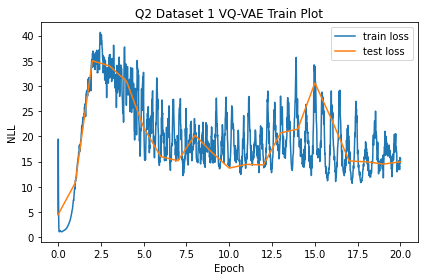

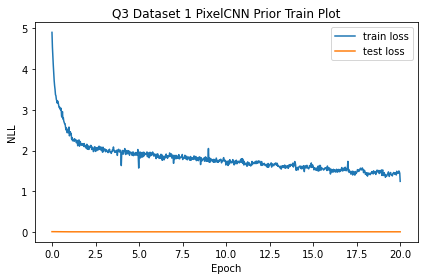

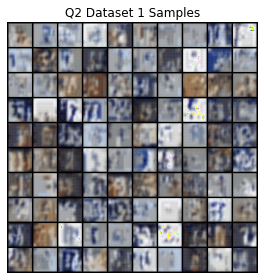

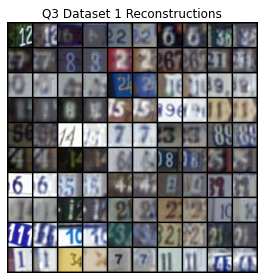

In [60]:
q2_save_results(1, q2)

VQ-VAE Final Test Loss: 0.0286
PixelCNN Prior Final Test Loss: 1.9440


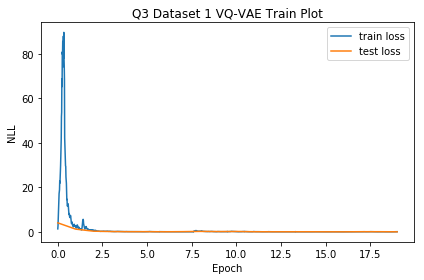

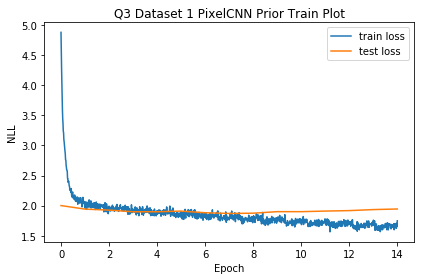

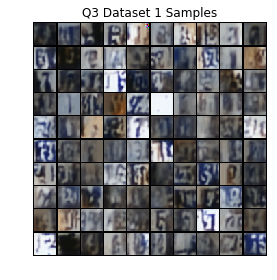

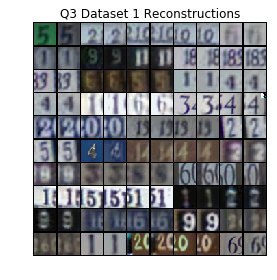

In [ ]:
q2_save_results(1, q2) # ref

In [ ]:
q2_save_results(2, q2)

# Bonus 4

## Part (a) Improving VQ-VAE Results
Improve upon your results in Q2, one option being trying to implement or train a stronger autoregressive model such as a Gated PixelCNN.

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def b4_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """

### Results
Once you've finished `b4_a`, execute the cells below to visualize and save your results.

In [ ]:
b4_a_save_results(2, b4_a)

## Part (b) PixelVAE
Implement and train a VAE with a PixelCNN decoder, and get it to produce good samples but not ignore latents. It may help to reference the latent variable model slides on techniques to prevent posterior collapse.

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def b4_b(train_data, test_data):
    """
    train_data: An (n_train, 28, 28, 1) uint8 numpy array of MNIST binary images
    test_data: An (n_test, 28, 28, 1) uint8 numpy array of MNIST binary images

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 28, 28, 1) numpy array of 100 samples with values in {0, 1}
    - a (100, 28, 28, 1) numpy array of 50 real-image / reconstruction pairs with values in {0, 1}
    """

    """ YOUR CODE HERE """ 

### Results
Once you've finished `b4_b`, execute the cells below to visualize and save your results

In [ ]:
b4_b_save_results(b4_b)